In [22]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import numpy as np
import os
import time
import pandas as pd

if not os.path.exists('./dc_img'):
    os.mkdir('./dc_img')

In [23]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [24]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [36]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),  # b, 8, 2, 2
            nn.Flatten(),
            nn.Linear(8*2*2, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(True),
            nn.Linear(16,10),
            nn.BatchNorm1d(10),
        )

    def forward(self, x):
        x = self.classifier(x)
        return x


In [57]:
class MNIST_Dataset(Dataset):
    
    def __init__(self, dataset, *args, **kwargs):
        
        super(MNIST_Dataset, self, *args, **kwargs).__init__()
        self.dataset=dataset
    
    def __getitem__(self, idx):
        tmp=self.dataset[idx]
        return [*tmp, idx]
    
    def __len__(self):
        return len(self.dataset)

In [58]:
def loss_fun(predicted, targets):
    loss = nn.CrossEntropyLoss()
    return loss(predicted, targets)
    # return nn.BCEWithLogitsLoss()(outputs, targets)

In [59]:
def train_loop_fun(data_loader, model, optimizer, device, scheduler=None):
    model.train()
    t0 = time.time()
    losses = []
    for batch_idx, (data, targets, data_idx) in enumerate(data_loader):
                
        optimizer.zero_grad()
        outputs = model(data)
        
        loss = loss_fun(outputs, targets)
        loss.backward()        
        model.float()
        optimizer.step()
        
        if scheduler:
            scheduler.step()
        losses.append(loss.item())
        if batch_idx % 150 == 0:
            print(
                f"___ batch index = {batch_idx} / {len(data_loader)} ({100*batch_idx / len(data_loader):.2f}%), loss = {np.mean(losses[-10:]):.4f}, time = {time.time()-t0:.2f} secondes ___")
            t0 = time.time()
    return losses

In [64]:
def eval_loop_fun(data_loader, model, device):
    model.eval()
    fin_targets = []
    fin_outputs = []
    losses = []
    for batch_idx, (data, targets, data_idx) in enumerate(data_loader):

        
        with torch.no_grad():
            outputs = model(data)
            loss = loss_fun(outputs, targets)
            losses.append(loss.item())

        fin_targets.append(targets.cpu().detach().numpy())
        fin_outputs.append(outputs.cpu().detach().numpy())
    return np.concatenate(fin_outputs), np.concatenate(fin_targets), losses
#     return np.vstack(fin_outputs), np.vstack(fin_targets), losses

In [65]:
def evaluate(target, predicted):
    true_label_mask = [1 if (np.argmax(x)-target[i]) ==
                       0 else 0 for i, x in enumerate(predicted)]
    nb_prediction = len(true_label_mask)
    true_prediction = sum(true_label_mask)
    false_prediction = nb_prediction-true_prediction
    accuracy = true_prediction/nb_prediction
    return{
        "accuracy": accuracy,
        "nb exemple": len(target),
        "true_prediction": true_prediction,
        "false_prediction": false_prediction,
    }

In [66]:
def choose_label_rand(dataset, nb_label, nb_class, train_indices):
    
    idx_label=[]
    nb_label_each_class=nb_label//nb_class
    
    early_stop=False
    
    if nb_label_each_class==0:
        print("The number of classes superior the number of desired labeled data.")
        print("This mean that some class(es) would not have example !")
        nb_label_each_class=1
        early_stop=True
    
    for i in range(nb_class):
        tmp=iter(dataset)
        idx_class=[datapoint[2] for datapoint in tmp if datapoint[1]==i and datapoint[2] in train_indices]
        idx_label.extend(np.random.choice(idx_class, nb_label_each_class, replace=False))
        print(f"Random index has been choosed for the class {i}")
        if early_stop and i+1 == nb_label:
            break
    
    return idx_label
    

In [68]:
TRAIN_BATCH_SIZE=16
EPOCH=250
validation_split = .2
shuffle_dataset = True
random_seed= 42
device="cpu"
nb_training_label=100
nb_class=10
learning_rate = 1e-3
lr=1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

print('Loading MNIST Dataset...')

dataset = MNIST('./data', transform=img_transform,train=True)# download=True)
mnist_dataset=MNIST_Dataset(dataset)

#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# idx_label=choose_label_rand(mnist_dataset, nb_training_label, nb_class, train_indices)

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(idx_label)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    mnist_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler)

valid_data_loader=DataLoader(
    mnist_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler)


num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

model = Classifier().to(device)
optimizer=Adam(model.parameters(), lr=lr, weight_decay=1e-5)
# optimizer=AdamW(model.parameters(), lr=lr)
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                         num_warmup_steps = 0,
#                                         num_training_steps = num_training_steps)

val_losses=[]
batches_losses=[]
val_acc=[]


for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp=train_loop_fun(train_data_loader, model, optimizer, device) #, idx_label)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"\n*** avg_loss : {epoch_loss:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp=eval_loop_fun(valid_data_loader, model, device)
    print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print(f"\t§§ Encoder model has been saved §§")
    torch.save(model, f"mnist/Baseline/Baseline_model_epoch{epoch+1}.pt")

Loading MNIST Dataset...

=============== EPOCH 1 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 2.6578, time = 0.03 secondes ___

*** avg_loss : 2.59, time : ~0.0 min (0.09 sec) ***

==> evaluation : avg_loss = 2.32, time : 2.36 sec

=====>	{'accuracy': 0.09808333333333333, 'nb exemple': 12000, 'true_prediction': 1177, 'false_prediction': 10823}
	§§ Encoder model has been saved §§

=============== EPOCH 2 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 2.5208, time = 0.03 secondes ___

*** avg_loss : 2.19, time : ~0.0 min (0.10 sec) ***

==> evaluation : avg_loss = 2.32, time : 2.31 sec

=====>	{'accuracy': 0.09808333333333333, 'nb exemple': 12000, 'true_prediction': 1177, 'false_prediction': 10823}
	§§ Encoder model has been saved §§

=============== EPOCH 3 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 2.0377, time = 0.01 secondes ___

*** avg_loss : 2.00, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = 2.31, time : 2.35 se

==> evaluation : avg_loss = 1.77, time : 2.64 sec

=====>	{'accuracy': 0.4266666666666667, 'nb exemple': 12000, 'true_prediction': 5120, 'false_prediction': 6880}
	§§ Encoder model has been saved §§

=============== EPOCH 24 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.8470, time = 0.02 secondes ___

*** avg_loss : 0.96, time : ~0.0 min (0.08 sec) ***

==> evaluation : avg_loss = 1.75, time : 2.60 sec

=====>	{'accuracy': 0.4285, 'nb exemple': 12000, 'true_prediction': 5142, 'false_prediction': 6858}
	§§ Encoder model has been saved §§

=============== EPOCH 25 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.8734, time = 0.01 secondes ___

*** avg_loss : 0.93, time : ~0.0 min (0.10 sec) ***

==> evaluation : avg_loss = 1.76, time : 2.60 sec

=====>	{'accuracy': 0.41475, 'nb exemple': 12000, 'true_prediction': 4977, 'false_prediction': 7023}
	§§ Encoder model has been saved §§

=============== EPOCH 26 / 500 ===============

___ batch index = 0 / 7 (

==> evaluation : avg_loss = 1.64, time : 2.72 sec

=====>	{'accuracy': 0.4558333333333333, 'nb exemple': 12000, 'true_prediction': 5470, 'false_prediction': 6530}
	§§ Encoder model has been saved §§

=============== EPOCH 47 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.7557, time = 0.01 secondes ___

*** avg_loss : 0.88, time : ~0.0 min (0.07 sec) ***

==> evaluation : avg_loss = 1.61, time : 2.71 sec

=====>	{'accuracy': 0.47975, 'nb exemple': 12000, 'true_prediction': 5757, 'false_prediction': 6243}
	§§ Encoder model has been saved §§

=============== EPOCH 48 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 1.0154, time = 0.01 secondes ___

*** avg_loss : 0.85, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = 1.64, time : 2.63 sec

=====>	{'accuracy': 0.47383333333333333, 'nb exemple': 12000, 'true_prediction': 5686, 'false_prediction': 6314}
	§§ Encoder model has been saved §§

=============== EPOCH 49 / 500 ===============

___ batch in

==> evaluation : avg_loss = 1.66, time : 2.60 sec

=====>	{'accuracy': 0.466, 'nb exemple': 12000, 'true_prediction': 5592, 'false_prediction': 6408}
	§§ Encoder model has been saved §§

=============== EPOCH 70 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.4559, time = 0.01 secondes ___

*** avg_loss : 0.64, time : ~0.0 min (0.10 sec) ***

==> evaluation : avg_loss = 1.61, time : 2.62 sec

=====>	{'accuracy': 0.4785, 'nb exemple': 12000, 'true_prediction': 5742, 'false_prediction': 6258}
	§§ Encoder model has been saved §§

=============== EPOCH 71 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.6407, time = 0.01 secondes ___

*** avg_loss : 0.70, time : ~0.0 min (0.09 sec) ***

==> evaluation : avg_loss = 1.58, time : 2.59 sec

=====>	{'accuracy': 0.4964166666666667, 'nb exemple': 12000, 'true_prediction': 5957, 'false_prediction': 6043}
	§§ Encoder model has been saved §§

=============== EPOCH 72 / 500 ===============

___ batch index = 0 / 7 (0.

==> evaluation : avg_loss = 1.53, time : 2.47 sec

=====>	{'accuracy': 0.5171666666666667, 'nb exemple': 12000, 'true_prediction': 6206, 'false_prediction': 5794}
	§§ Encoder model has been saved §§

=============== EPOCH 93 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.4445, time = 0.01 secondes ___

*** avg_loss : 0.47, time : ~0.0 min (0.07 sec) ***

==> evaluation : avg_loss = 1.52, time : 2.52 sec

=====>	{'accuracy': 0.5281666666666667, 'nb exemple': 12000, 'true_prediction': 6338, 'false_prediction': 5662}
	§§ Encoder model has been saved §§

=============== EPOCH 94 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.5815, time = 0.01 secondes ___

*** avg_loss : 0.64, time : ~0.0 min (0.07 sec) ***

==> evaluation : avg_loss = 1.47, time : 2.53 sec

=====>	{'accuracy': 0.5409166666666667, 'nb exemple': 12000, 'true_prediction': 6491, 'false_prediction': 5509}
	§§ Encoder model has been saved §§

=============== EPOCH 95 / 500 ===============

__

==> evaluation : avg_loss = 1.47, time : 2.86 sec

=====>	{'accuracy': 0.5345833333333333, 'nb exemple': 12000, 'true_prediction': 6415, 'false_prediction': 5585}
	§§ Encoder model has been saved §§

=============== EPOCH 115 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.6110, time = 0.01 secondes ___

*** avg_loss : 0.56, time : ~0.0 min (0.08 sec) ***

==> evaluation : avg_loss = 1.46, time : 2.88 sec

=====>	{'accuracy': 0.5400833333333334, 'nb exemple': 12000, 'true_prediction': 6481, 'false_prediction': 5519}
	§§ Encoder model has been saved §§

=============== EPOCH 116 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.6219, time = 0.01 secondes ___

*** avg_loss : 0.57, time : ~0.0 min (0.08 sec) ***

==> evaluation : avg_loss = 1.51, time : 2.59 sec

=====>	{'accuracy': 0.5176666666666667, 'nb exemple': 12000, 'true_prediction': 6212, 'false_prediction': 5788}
	§§ Encoder model has been saved §§

=============== EPOCH 117 / 500 ===============


==> evaluation : avg_loss = 1.70, time : 2.58 sec

=====>	{'accuracy': 0.4701666666666667, 'nb exemple': 12000, 'true_prediction': 5642, 'false_prediction': 6358}
	§§ Encoder model has been saved §§

=============== EPOCH 137 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.5455, time = 0.03 secondes ___

*** avg_loss : 0.64, time : ~0.0 min (0.18 sec) ***

==> evaluation : avg_loss = 1.64, time : 2.68 sec

=====>	{'accuracy': 0.4850833333333333, 'nb exemple': 12000, 'true_prediction': 5821, 'false_prediction': 6179}
	§§ Encoder model has been saved §§

=============== EPOCH 138 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.8414, time = 0.01 secondes ___

*** avg_loss : 0.67, time : ~0.0 min (0.07 sec) ***

==> evaluation : avg_loss = 1.59, time : 2.65 sec

=====>	{'accuracy': 0.49916666666666665, 'nb exemple': 12000, 'true_prediction': 5990, 'false_prediction': 6010}
	§§ Encoder model has been saved §§

=============== EPOCH 139 / 500 ===============

==> evaluation : avg_loss = 1.50, time : 2.70 sec

=====>	{'accuracy': 0.524, 'nb exemple': 12000, 'true_prediction': 6288, 'false_prediction': 5712}
	§§ Encoder model has been saved §§

=============== EPOCH 159 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.2015, time = 0.02 secondes ___

*** avg_loss : 0.34, time : ~0.0 min (0.08 sec) ***

==> evaluation : avg_loss = 1.48, time : 2.75 sec

=====>	{'accuracy': 0.533, 'nb exemple': 12000, 'true_prediction': 6396, 'false_prediction': 5604}
	§§ Encoder model has been saved §§

=============== EPOCH 160 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.5463, time = 0.01 secondes ___

*** avg_loss : 0.39, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = 1.47, time : 2.60 sec

=====>	{'accuracy': 0.5380833333333334, 'nb exemple': 12000, 'true_prediction': 6457, 'false_prediction': 5543}
	§§ Encoder model has been saved §§

=============== EPOCH 161 / 500 ===============

___ batch index = 0 / 7 (

==> evaluation : avg_loss = 1.62, time : 2.58 sec

=====>	{'accuracy': 0.48933333333333334, 'nb exemple': 12000, 'true_prediction': 5872, 'false_prediction': 6128}
	§§ Encoder model has been saved §§

=============== EPOCH 181 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.2981, time = 0.02 secondes ___

*** avg_loss : 0.43, time : ~0.0 min (0.14 sec) ***

==> evaluation : avg_loss = 1.56, time : 2.68 sec

=====>	{'accuracy': 0.51075, 'nb exemple': 12000, 'true_prediction': 6129, 'false_prediction': 5871}
	§§ Encoder model has been saved §§

=============== EPOCH 182 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.3431, time = 0.01 secondes ___

*** avg_loss : 0.50, time : ~0.0 min (0.07 sec) ***

==> evaluation : avg_loss = 1.50, time : 2.65 sec

=====>	{'accuracy': 0.5286666666666666, 'nb exemple': 12000, 'true_prediction': 6344, 'false_prediction': 5656}
	§§ Encoder model has been saved §§

=============== EPOCH 183 / 500 ===============

___ batch

==> evaluation : avg_loss = 1.45, time : 2.78 sec

=====>	{'accuracy': 0.5455833333333333, 'nb exemple': 12000, 'true_prediction': 6547, 'false_prediction': 5453}
	§§ Encoder model has been saved §§

=============== EPOCH 203 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.2980, time = 0.01 secondes ___

*** avg_loss : 0.51, time : ~0.0 min (0.07 sec) ***

==> evaluation : avg_loss = 1.47, time : 2.72 sec

=====>	{'accuracy': 0.535, 'nb exemple': 12000, 'true_prediction': 6420, 'false_prediction': 5580}
	§§ Encoder model has been saved §§

=============== EPOCH 204 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.1032, time = 0.02 secondes ___

*** avg_loss : 0.44, time : ~0.0 min (0.13 sec) ***

==> evaluation : avg_loss = 1.48, time : 2.67 sec

=====>	{'accuracy': 0.5246666666666666, 'nb exemple': 12000, 'true_prediction': 6296, 'false_prediction': 5704}
	§§ Encoder model has been saved §§

=============== EPOCH 205 / 500 ===============

___ batch in

==> evaluation : avg_loss = 1.47, time : 2.51 sec

=====>	{'accuracy': 0.53425, 'nb exemple': 12000, 'true_prediction': 6411, 'false_prediction': 5589}
	§§ Encoder model has been saved §§

=============== EPOCH 226 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.3980, time = 0.04 secondes ___

*** avg_loss : 0.44, time : ~0.0 min (0.20 sec) ***

==> evaluation : avg_loss = 1.40, time : 2.64 sec

=====>	{'accuracy': 0.5601666666666667, 'nb exemple': 12000, 'true_prediction': 6722, 'false_prediction': 5278}
	§§ Encoder model has been saved §§

=============== EPOCH 227 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.4245, time = 0.01 secondes ___

*** avg_loss : 0.36, time : ~0.0 min (0.08 sec) ***

==> evaluation : avg_loss = 1.40, time : 2.69 sec

=====>	{'accuracy': 0.5626666666666666, 'nb exemple': 12000, 'true_prediction': 6752, 'false_prediction': 5248}
	§§ Encoder model has been saved §§

=============== EPOCH 228 / 500 ===============

___ batch 

==> evaluation : avg_loss = 1.40, time : 2.64 sec

=====>	{'accuracy': 0.5550833333333334, 'nb exemple': 12000, 'true_prediction': 6661, 'false_prediction': 5339}
	§§ Encoder model has been saved §§

=============== EPOCH 249 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.3644, time = 0.03 secondes ___

*** avg_loss : 0.39, time : ~0.0 min (0.10 sec) ***

==> evaluation : avg_loss = 1.44, time : 2.73 sec

=====>	{'accuracy': 0.546, 'nb exemple': 12000, 'true_prediction': 6552, 'false_prediction': 5448}
	§§ Encoder model has been saved §§

=============== EPOCH 250 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.2668, time = 0.02 secondes ___

*** avg_loss : 0.38, time : ~0.0 min (0.12 sec) ***

==> evaluation : avg_loss = 1.45, time : 2.78 sec

=====>	{'accuracy': 0.5451666666666667, 'nb exemple': 12000, 'true_prediction': 6542, 'false_prediction': 5458}
	§§ Encoder model has been saved §§

=============== EPOCH 251 / 500 ===============

___ batch in

==> evaluation : avg_loss = 1.45, time : 2.74 sec

=====>	{'accuracy': 0.5493333333333333, 'nb exemple': 12000, 'true_prediction': 6592, 'false_prediction': 5408}
	§§ Encoder model has been saved §§

=============== EPOCH 272 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.2281, time = 0.01 secondes ___

*** avg_loss : 0.34, time : ~0.0 min (0.09 sec) ***

==> evaluation : avg_loss = 1.42, time : 2.69 sec

=====>	{'accuracy': 0.5539166666666666, 'nb exemple': 12000, 'true_prediction': 6647, 'false_prediction': 5353}
	§§ Encoder model has been saved §§

=============== EPOCH 273 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.1784, time = 0.01 secondes ___

*** avg_loss : 0.34, time : ~0.0 min (0.07 sec) ***

==> evaluation : avg_loss = 1.41, time : 2.76 sec

=====>	{'accuracy': 0.5588333333333333, 'nb exemple': 12000, 'true_prediction': 6706, 'false_prediction': 5294}
	§§ Encoder model has been saved §§

=============== EPOCH 274 / 500 ===============


==> evaluation : avg_loss = 1.46, time : 2.69 sec

=====>	{'accuracy': 0.5451666666666667, 'nb exemple': 12000, 'true_prediction': 6542, 'false_prediction': 5458}
	§§ Encoder model has been saved §§

=============== EPOCH 295 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.2336, time = 0.01 secondes ___

*** avg_loss : 0.27, time : ~0.0 min (0.07 sec) ***

==> evaluation : avg_loss = 1.42, time : 2.67 sec

=====>	{'accuracy': 0.55375, 'nb exemple': 12000, 'true_prediction': 6645, 'false_prediction': 5355}
	§§ Encoder model has been saved §§

=============== EPOCH 296 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.2020, time = 0.01 secondes ___

*** avg_loss : 0.23, time : ~0.0 min (0.08 sec) ***

==> evaluation : avg_loss = 1.46, time : 2.81 sec

=====>	{'accuracy': 0.5418333333333333, 'nb exemple': 12000, 'true_prediction': 6502, 'false_prediction': 5498}
	§§ Encoder model has been saved §§

=============== EPOCH 297 / 500 ===============

___ batch 

==> evaluation : avg_loss = 1.38, time : 2.91 sec

=====>	{'accuracy': 0.5693333333333334, 'nb exemple': 12000, 'true_prediction': 6832, 'false_prediction': 5168}
	§§ Encoder model has been saved §§

=============== EPOCH 318 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.1396, time = 0.01 secondes ___

*** avg_loss : 0.28, time : ~0.0 min (0.10 sec) ***

==> evaluation : avg_loss = 1.37, time : 2.82 sec

=====>	{'accuracy': 0.5714166666666667, 'nb exemple': 12000, 'true_prediction': 6857, 'false_prediction': 5143}
	§§ Encoder model has been saved §§

=============== EPOCH 319 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.1326, time = 0.02 secondes ___

*** avg_loss : 0.34, time : ~0.0 min (0.12 sec) ***

==> evaluation : avg_loss = 1.36, time : 2.77 sec

=====>	{'accuracy': 0.5750833333333333, 'nb exemple': 12000, 'true_prediction': 6901, 'false_prediction': 5099}
	§§ Encoder model has been saved §§

=============== EPOCH 320 / 500 ===============


==> evaluation : avg_loss = 1.35, time : 2.91 sec

=====>	{'accuracy': 0.5813333333333334, 'nb exemple': 12000, 'true_prediction': 6976, 'false_prediction': 5024}
	§§ Encoder model has been saved §§

=============== EPOCH 341 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.2017, time = 0.03 secondes ___

*** avg_loss : 0.33, time : ~0.0 min (0.16 sec) ***

==> evaluation : avg_loss = 1.34, time : 2.85 sec

=====>	{'accuracy': 0.58175, 'nb exemple': 12000, 'true_prediction': 6981, 'false_prediction': 5019}
	§§ Encoder model has been saved §§

=============== EPOCH 342 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.0501, time = 0.06 secondes ___

*** avg_loss : 0.30, time : ~0.0 min (0.15 sec) ***

==> evaluation : avg_loss = 1.39, time : 2.78 sec

=====>	{'accuracy': 0.5656666666666667, 'nb exemple': 12000, 'true_prediction': 6788, 'false_prediction': 5212}
	§§ Encoder model has been saved §§

=============== EPOCH 343 / 500 ===============

___ batch 

==> evaluation : avg_loss = 1.41, time : 2.66 sec

=====>	{'accuracy': 0.5691666666666667, 'nb exemple': 12000, 'true_prediction': 6830, 'false_prediction': 5170}
	§§ Encoder model has been saved §§

=============== EPOCH 363 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.2823, time = 0.01 secondes ___

*** avg_loss : 0.38, time : ~0.0 min (0.08 sec) ***

==> evaluation : avg_loss = 1.53, time : 2.84 sec

=====>	{'accuracy': 0.5398333333333334, 'nb exemple': 12000, 'true_prediction': 6478, 'false_prediction': 5522}
	§§ Encoder model has been saved §§

=============== EPOCH 364 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.1670, time = 0.02 secondes ___

*** avg_loss : 0.33, time : ~0.0 min (0.11 sec) ***

==> evaluation : avg_loss = 1.53, time : 2.85 sec

=====>	{'accuracy': 0.5343333333333333, 'nb exemple': 12000, 'true_prediction': 6412, 'false_prediction': 5588}
	§§ Encoder model has been saved §§

=============== EPOCH 365 / 500 ===============


==> evaluation : avg_loss = 1.36, time : 2.72 sec

=====>	{'accuracy': 0.586, 'nb exemple': 12000, 'true_prediction': 7032, 'false_prediction': 4968}
	§§ Encoder model has been saved §§

=============== EPOCH 386 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.2137, time = 0.01 secondes ___

*** avg_loss : 0.23, time : ~0.0 min (0.07 sec) ***

==> evaluation : avg_loss = 1.36, time : 2.67 sec

=====>	{'accuracy': 0.5870833333333333, 'nb exemple': 12000, 'true_prediction': 7045, 'false_prediction': 4955}
	§§ Encoder model has been saved §§

=============== EPOCH 387 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.3897, time = 0.02 secondes ___

*** avg_loss : 0.30, time : ~0.0 min (0.08 sec) ***

==> evaluation : avg_loss = 1.34, time : 2.65 sec

=====>	{'accuracy': 0.5901666666666666, 'nb exemple': 12000, 'true_prediction': 7082, 'false_prediction': 4918}
	§§ Encoder model has been saved §§

=============== EPOCH 388 / 500 ===============

___ batch in

==> evaluation : avg_loss = 1.32, time : 2.60 sec

=====>	{'accuracy': 0.5841666666666666, 'nb exemple': 12000, 'true_prediction': 7010, 'false_prediction': 4990}
	§§ Encoder model has been saved §§

=============== EPOCH 408 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.2169, time = 0.03 secondes ___

*** avg_loss : 0.27, time : ~0.0 min (0.10 sec) ***

==> evaluation : avg_loss = 1.29, time : 3.07 sec

=====>	{'accuracy': 0.5944166666666667, 'nb exemple': 12000, 'true_prediction': 7133, 'false_prediction': 4867}
	§§ Encoder model has been saved §§

=============== EPOCH 409 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.1485, time = 0.01 secondes ___

*** avg_loss : 0.26, time : ~0.0 min (0.07 sec) ***

==> evaluation : avg_loss = 1.28, time : 2.66 sec

=====>	{'accuracy': 0.59275, 'nb exemple': 12000, 'true_prediction': 7113, 'false_prediction': 4887}
	§§ Encoder model has been saved §§

=============== EPOCH 410 / 500 ===============

___ batch 

==> evaluation : avg_loss = 1.28, time : 2.77 sec

=====>	{'accuracy': 0.605, 'nb exemple': 12000, 'true_prediction': 7260, 'false_prediction': 4740}
	§§ Encoder model has been saved §§

=============== EPOCH 430 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.1868, time = 0.01 secondes ___

*** avg_loss : 0.23, time : ~0.0 min (0.07 sec) ***

==> evaluation : avg_loss = 1.36, time : 2.61 sec

=====>	{'accuracy': 0.5878333333333333, 'nb exemple': 12000, 'true_prediction': 7054, 'false_prediction': 4946}
	§§ Encoder model has been saved §§

=============== EPOCH 431 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.1762, time = 0.01 secondes ___

*** avg_loss : 0.29, time : ~0.0 min (0.09 sec) ***

==> evaluation : avg_loss = 1.36, time : 2.56 sec

=====>	{'accuracy': 0.5868333333333333, 'nb exemple': 12000, 'true_prediction': 7042, 'false_prediction': 4958}
	§§ Encoder model has been saved §§

=============== EPOCH 432 / 500 ===============

___ batch in

==> evaluation : avg_loss = 1.37, time : 2.59 sec

=====>	{'accuracy': 0.58525, 'nb exemple': 12000, 'true_prediction': 7023, 'false_prediction': 4977}
	§§ Encoder model has been saved §§

=============== EPOCH 453 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.1861, time = 0.02 secondes ___

*** avg_loss : 0.23, time : ~0.0 min (0.08 sec) ***

==> evaluation : avg_loss = 1.37, time : 2.64 sec

=====>	{'accuracy': 0.5793333333333334, 'nb exemple': 12000, 'true_prediction': 6952, 'false_prediction': 5048}
	§§ Encoder model has been saved §§

=============== EPOCH 454 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.1815, time = 0.01 secondes ___

*** avg_loss : 0.17, time : ~0.0 min (0.12 sec) ***

==> evaluation : avg_loss = 1.34, time : 2.79 sec

=====>	{'accuracy': 0.5903333333333334, 'nb exemple': 12000, 'true_prediction': 7084, 'false_prediction': 4916}
	§§ Encoder model has been saved §§

=============== EPOCH 455 / 500 ===============

___ batch 

==> evaluation : avg_loss = 1.44, time : 2.65 sec

=====>	{'accuracy': 0.5683333333333334, 'nb exemple': 12000, 'true_prediction': 6820, 'false_prediction': 5180}
	§§ Encoder model has been saved §§

=============== EPOCH 475 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.1469, time = 0.01 secondes ___

*** avg_loss : 0.30, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = 1.37, time : 2.69 sec

=====>	{'accuracy': 0.5804166666666667, 'nb exemple': 12000, 'true_prediction': 6965, 'false_prediction': 5035}
	§§ Encoder model has been saved §§

=============== EPOCH 476 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.0387, time = 0.01 secondes ___

*** avg_loss : 0.19, time : ~0.0 min (0.07 sec) ***

==> evaluation : avg_loss = 1.36, time : 2.72 sec

=====>	{'accuracy': 0.5841666666666666, 'nb exemple': 12000, 'true_prediction': 7010, 'false_prediction': 4990}
	§§ Encoder model has been saved §§

=============== EPOCH 477 / 500 ===============


==> evaluation : avg_loss = 1.56, time : 2.71 sec

=====>	{'accuracy': 0.5228333333333334, 'nb exemple': 12000, 'true_prediction': 6274, 'false_prediction': 5726}
	§§ Encoder model has been saved §§

=============== EPOCH 497 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.2507, time = 0.01 secondes ___

*** avg_loss : 0.38, time : ~0.0 min (0.07 sec) ***

==> evaluation : avg_loss = 1.58, time : 2.64 sec

=====>	{'accuracy': 0.5083333333333333, 'nb exemple': 12000, 'true_prediction': 6100, 'false_prediction': 5900}
	§§ Encoder model has been saved §§

=============== EPOCH 498 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = 0.0921, time = 0.01 secondes ___

*** avg_loss : 0.28, time : ~0.0 min (0.07 sec) ***

==> evaluation : avg_loss = 1.50, time : 2.62 sec

=====>	{'accuracy': 0.5385833333333333, 'nb exemple': 12000, 'true_prediction': 6463, 'false_prediction': 5537}
	§§ Encoder model has been saved §§

=============== EPOCH 499 / 500 ===============


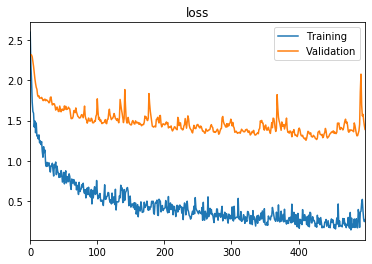

In [69]:
pd.DataFrame(np.array([[np.mean(x) for x in batches_losses], [np.mean(x) for x in val_losses]]).T,
                   columns=['Training', 'Validation']).plot(title="loss")

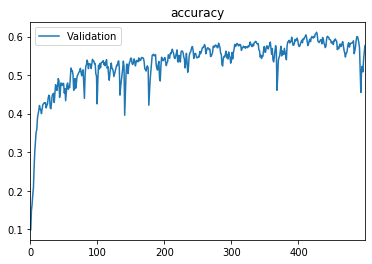

In [70]:
pd.DataFrame(np.array(val_acc).T,
                   columns=['Validation']).plot(title="accuracy")

In [71]:
print(f"maximal Accuracy of {round(max(val_acc),2)} on the epoch {np.argmax(val_acc)+1}")

maximal Accuracy of 0.61 on the epoch 428


In [75]:
# test on MNIST

model_test=torch.load("./mnist/Baseline/Baseline_model_epoch428.pt")
test_losses=[]
test_acc=[]
t1=time.time()
test_dataset = MNIST('./data', transform=img_transform,train=False)# download=True)
test_mnist_dataset=MNIST_Dataset(test_dataset)
test_data_loader=DataLoader(
    test_mnist_dataset,
    batch_size=TRAIN_BATCH_SIZE)
output, target, test_losses_tmp=eval_loop_fun(test_data_loader, model_test, device)
print(f"==> evaluation : avg_loss = {np.mean(test_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")
test_evaluate=evaluate(target.reshape(-1), output)
print(f"=====>\t{test_evaluate}")
test_acc.append(test_evaluate['accuracy'])
test_losses.append(test_losses_tmp)
    

==> evaluation : avg_loss = 1.23, time : 1.89 sec

=====>	{'accuracy': 0.6201, 'nb exemple': 10000, 'true_prediction': 6201, 'false_prediction': 3799}


In [72]:
model

Classifier(
  (classifier): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten()
    (7): Linear(in_features=32, out_features=32, bias=True)
    (8): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Linear(in_features=32, out_features=16, bias=True)
    (11): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Linear(in_features=16, out_features=10, bias=True)
    (14): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)